# GDAL vs SAGA using GEOtiled

This notebook compares the execution time of using GDAL or SAGA to compute parameters using GEOtiled.

## Preconfiguration

Import needed libaries to run notebook.

In [1]:
import compute_functions as cm
import geotiled
import shutil
import time

Set variables to run test.

Do not specify tile sizes that would cause the final file count to exceed the number of cores available for the best performance results.

In [2]:
# The working directory to store files in
working_directory = '/media/volume/geotiled-saga/gdal_saga_geotiled_test'
geotiled.set_working_directory(working_directory)

# Size of tiles to produce specified as a list of [x,y] values (units of pixels)
tile_sizes = [[18274,16862],[18274,8431],[9137,8431],[9137,4216],[4569,4216]]

# Data to download
resolution = '30m'
region = 'TN'

# Data to compute
parameters = ['slope','aspect']

# Number of runs to do
runs = 10

In [9]:
# Create CSV file
file = open('results.csv', 'w')
file.write('method,parameter,tile_size,run_number,execution_time\n')
file.close()

## Initialization

Download and preprocess data.

In [10]:
# Download the desired data
geotiled.fetch_dem(shapefile=region, dataset=resolution, save_to_txt=False, download=True)

# Mosaic DEMs
geotiled.build_mosaic(input_folder='dem_tiles', output_file='mosaic.tif', description='Elevation')

# Reproject mosaic into computable format
geotiled.reproject(input_file='mosaic.tif', output_file='elevation.tif', projection='EPSG:26918')



ownloading: 100%|█████████████████████████████████████████████| 1.72G/1.72G [00:17<00:00, 95.8MB/s]

## Compute with GDAL

Compute parameters using GEOtiled and GDAL.

In [3]:
for ts in tile_sizes:
    for param in parameters:
        for i in range(runs):
            # Compute with GEOtiled using GDAL
            start_time = time.time()
            geotiled.crop_and_compute(input_file='elevation.tif', column_length=ts[0], row_length=ts[1], parameter_list=[param], compute_method='GDAL')
            geotiled.build_mosaic(input_folder=f"unbuffered_{param}_tiles", output_file=f"gdal_{param}.tif")
            run_time = time.time() - start_time

            # Update CSV
            file = open('results.csv', 'a')
            file.write(f"GDAL,{param},{ts[0]}x{ts[1]},{i},{run_time}\n")
            file.close()

## Compute with SAGA

Compute parameters using GEOtiled and SAGA.

In [4]:
# Cleanup files to prevent issues with next test
shutil.rmtree('elevation_tiles')
for param in parameters:
    shutil.rmtree(f"unbuffered_{param}_tiles")
    shutil.rmtree(f"{param}_tiles")

In [5]:
for ts in tile_sizes:
    for param in parameters:
        for i in range(runs):
            # Compute with GEOtiled using GDAL
            start_time = time.time()
            geotiled.crop_and_compute(input_file='elevation.tif', column_length=ts[0], row_length=ts[1], parameter_list=[param], compute_method='SAGA')
            geotiled.build_mosaic(input_folder=f"unbuffered_{param}_tiles", output_file=f"saga_{param}.tif")
            run_time = time.time() - start_time

            # Update CSV
            file = open('results.csv', 'a')
            file.write(f"SAGA,{param},{ts[0]}x{ts[1]},{i},{run_time}\n")
            file.close()

## Visualize Results

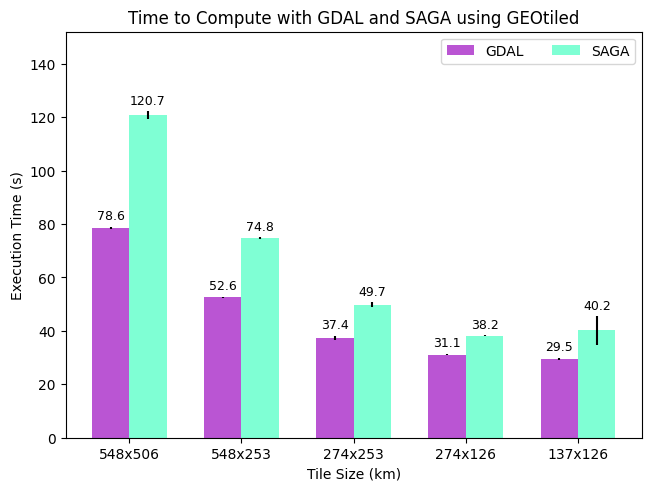

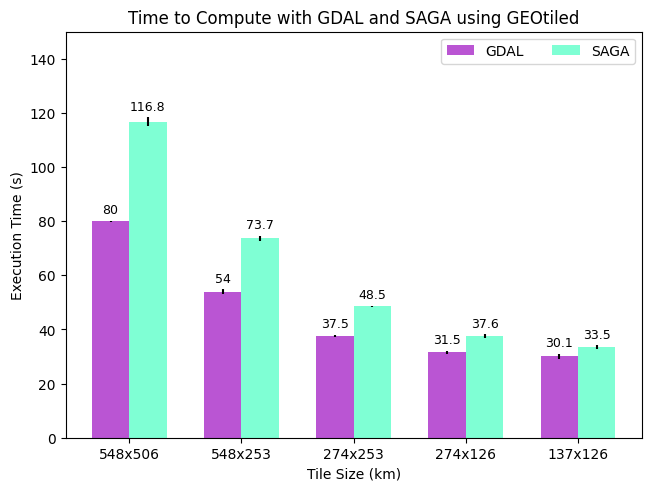

In [3]:
cm.plot_geotiled_results('results.csv','slope')
cm.plot_geotiled_results('results.csv','aspect')

### End of Notebook